# PF calibration plots 
The following is calibration assesment of PF inference. First using 
[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html) and next trying to replicate results by creating the code from scratch, because the Scikit-learn did not give the exactly desired results. The tool itself required binary classification, but PF is a multi-class classifier. So in order to create binary classification problem, ["one vs all"](https://arxiv.org/pdf/1706.04599.pdf) methology was implimented.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import wget
import sklearn.calibration as calib
from scipy.special import softmax
import pickle as pkl

In [3]:
#Load file and assign values to dictionaries,
fi = np.load("pred_ttbar.npz")
list(fi.keys())
ygen = fi["ygen"]
ycand = fi["ycand"]
ypred = fi["ypred"]
ypred_raw = fi["ypred_raw"]
X=fi["X"]

In [4]:
#Concatate all matricies
conc_ygen = np.concatenate(ygen[0:ygen.shape[0]])
conc_ypred= np.concatenate(ypred[0:ygen.shape[0]])
#extract ids
ygen_ids=conc_ygen[:,0]
ypred_ids=conc_ypred[:,0]

In [5]:
#particle ID (type is)
#0 - no particle
#1 - charged hadron
#2 - neutral hadron
#3 - photon
#4 - electron
#5 - muon
print(np.unique(ygen_ids, return_counts=True))
print(ygen_ids.shape)

(array([0., 1., 2., 3., 4., 5.], dtype=float32), array([ 7663884, 13044957,  4640009,  6593439,    44044,    13667],
      dtype=int64))
(32000000,)


In [6]:
#Create binary problems with ground truth
#1st example data
#Particle(1) vs no particle(0)
ygen_ids_b=np.where(ygen_ids>0,1,ygen_ids)
#ypred_ids_b=np.where(ypred_ids>0,1,ypred_ids)
print(np.unique(ygen_ids_b, return_counts=True))

#Charged hadron(1) vs else(0)
ygen_ids_CHb=np.where(ygen_ids != 1,0,ygen_ids)
print(np.unique(ygen_ids_CHb, return_counts=True))

#Neutral hadron(1) vs else(0)
ygen_ids_NHb=np.where(ygen_ids != 2,0,ygen_ids)
ygen_ids_NHb=np.where(ygen_ids_NHb == 2,1,ygen_ids_NHb)
print(np.unique(ygen_ids_NHb, return_counts=True))

(array([0., 1.], dtype=float32), array([ 7663884, 24336116], dtype=int64))
(array([0., 1.], dtype=float32), array([18955043, 13044957], dtype=int64))
(array([0., 1.], dtype=float32), array([27359991,  4640009], dtype=int64))


In [7]:
#Concatntate and change to binary the raw prediction values using softmax function. Creating binary problem with predictions.
ypred_raw_conc=np.concatenate(ypred_raw[0:ypred.shape[0]])
ypred_sm=softmax(ypred_raw_conc,axis=1)

In [ ]:
#converting raw probabilities into binary. y_pred: Particle(1) Vs NO Particle(0) "ypred_PVNP"
n_events=len(ygen_ids)
ypred_PVNP=[]
for i in range(n_events):
    n_bin=[]
    ypred_NP_prob=ypred_sm[i][0] #probability of no particle
    n_bin.append(ypred_NP_prob) 
    n_bin.append(1-ypred_NP_prob)
    #print(n_bin)
    ypred_PVNP.append(n_bin)
#convert to array
ypred_PVNP=np.asarray(ypred_PVNP)

In [ ]:
#ypred_CH=ypred_sm[1] #Charged hadron probability
ypred_CH=[]
for i in range(n_events):
    n_bin=[]
    CH_prob = ypred_sm[i][1]
    n_bin.append(1-CH_prob)
    n_bin.append(CH_prob)
    #print(n_bin)
    ypred_CH.append(n_bin)
#convert to array
ypred_CH=np.asarray(ypred_CH)

In [ ]:
#ypred_NH=ypred_sm[2] #Neutralhadron
ypred_NH=[]
for i in range(n_events):
    n_bin=[]
    NH_prob = ypred_sm[i][2]
    n_bin.append(1-NH_prob)
    n_bin.append(NH_prob)
    #print(n_bin)
    ypred_NH.append(n_bin)
#convert to array
ypred_NH=np.asarray(ypred_NH)

In [ ]:
###In order to save time it is recommended to save the binary data to seperate file so it takes less time to change test data.
###Dictionary for pickling
Dict={}
Dict["ypred_PVNP"]=ypred_PVNP
Dict["ypred_CH"]=ypred_CH
Dict["ypred_NH"]=ypred_NH
###Pickling
#pickle_out = open("1st_example_calib_data","wb")
pkl.dump(Dict, pickle_out)
pickle_out.close()


In [9]:
###LOAD PICKLE
pickle_in = open("TTbar_calib_data","rb")
examp_dict = pkl.load(pickle_in)
ypred_PVNP=examp_dict["ypred_PVNP"]
ypred_CH=examp_dict["ypred_CH"]
ypred_NH=examp_dict["ypred_NH"]

In [10]:
#separate probability that an particle is detected form conf
ypred_1=ypred_PVNP[:,1]
#separate probability that an Charged Hadron is detected form conf
ypred_CH1=ypred_CH[:,1]
#separate probability that an Neutral Hadron is detected form conf
ypred_NH1=ypred_NH[:,1]

In [11]:
##calculating error for fraction of positives in a bin for certain confidence/mean predicted value bins.
def error(A,B):
    dA=np.sqrt(A)
    dB=np.sqrt(B)
    C= A/(A+B)
    dC_dA=B/((A+B)**2)
    dC_dB=-A/((A+B)**2)
    errors=np.sqrt(((dC_dA*dA)**2)+((dC_dB*dB)**2))
    return C,errors



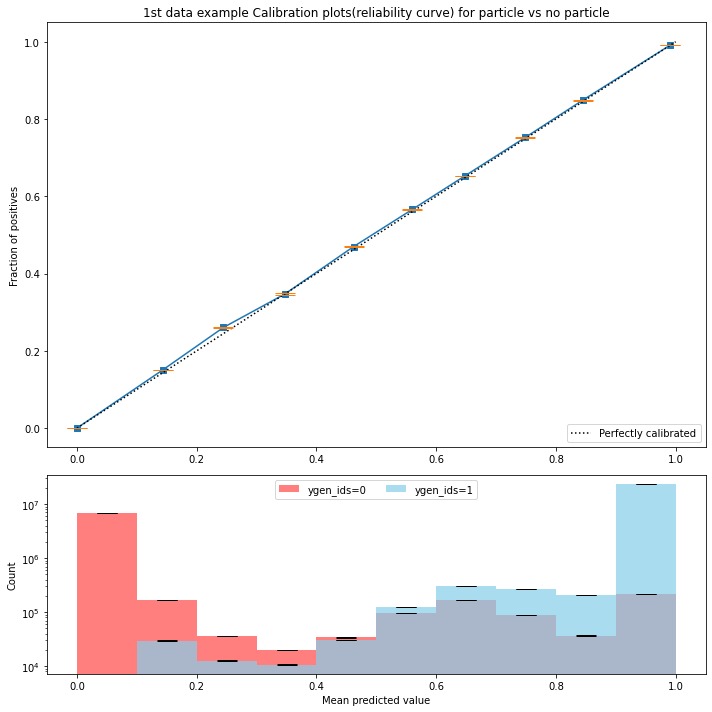

In [12]:
#calibration curve sklearn
fraction_of_positives, mean_predicted_value=calib.calibration_curve(ygen_ids_b,ypred_1,normalize=True,n_bins=10,strategy="uniform")
#plotting https://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html#sphx-glr-auto-examples-calibration-plot-compare-calibration-py

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot(mean_predicted_value, fraction_of_positives, "s-",)

bins = np.linspace(0,1,len(fraction_of_positives)+1)
n_0, bins_0,_=ax2.hist(ypred_PVNP[ygen_ids_b==0,1],density=False,log=True,bins=bins,color = "red",alpha=0.5,label="ygen_ids=0")
n_1, bins_1,_ =ax2.hist(ypred_PVNP[ygen_ids_b==1,1],density=False,log=True,bins=bins,color = "skyblue",alpha=0.7,label="ygen_ids=1")
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('1st data example Calibration plots(reliability curve) for particle vs no particle')
#ax1 error
ax1_C ,ax1_errors  =  error(n_1,n_0)
yerr1 = ax1_errors
ax1.errorbar(mean_predicted_value, ax1_C, yerr=yerr1, fmt='none',capsize =10)




ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)
#ax2 error histogram
ax2_C ,ax2_errors  =  error(n_1,n_0)
yerr2 = ax2_errors
bin_centers_0 = 0.5*(bins_0[1:] + bins_0[:-1])
bin_centers_1 = 0.5*(bins_1[1:] + bins_1[:-1])

yerr_0=np.sqrt(n_0)
yerr_1=np.sqrt(n_1)
ax2.errorbar(
    bin_centers_0,
    n_0,
    yerr = yerr_0,
    fmt="none",
    ecolor="black",
    capsize =10
)
ax2.errorbar(
    bin_centers_1,
    n_1,
    yerr = yerr_1,
    fmt="none",
    ecolor ="black",
    capsize =10
    
)


plt.tight_layout()
#plt.savefig('Particle_vs_no_1st_example_data.png')
plt.show()

In [ ]:
##Testing new  calibration curve
bins = np.linspace(0,1,8)
confidences , accuracies,_ =calibration_curve(ygen_ids_CHb,ypred_CH1,bins)

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.set_title('1st data example Calibration plots(reliability curve) for particle vs no particle')
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax1.legend(loc="lower right")
ax1.plot(confidences,accuracies, "s-",)

n_0, bins_0,_=ax2.hist(ypred_CH[ygen_ids_CHb==0,1],density=False,log=True,bins=bins,color = "red",alpha=0.5,label="ygen_ids=0")
n_1, bins_1,_ =ax2.hist(ypred_CH[ygen_ids_CHb==1,1],density=False,log=True,bins=bins,color = "skyblue",alpha=0.7,label="ygen_ids=1")
ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

ax1_C,ax1_errors  =  error(n_1,n_0)
yerr1 = ax1_errors
ax1.errorbar(confidences, ax1_C, yerr=yerr1, fmt='none',capsize =10)

#plt.savefig('Particle_vs_no_test.png')

[1.12348855e-05 7.89822554e-04 5.15110406e-04 1.27073437e-03
 2.19089023e-01 1.13819593e-07]


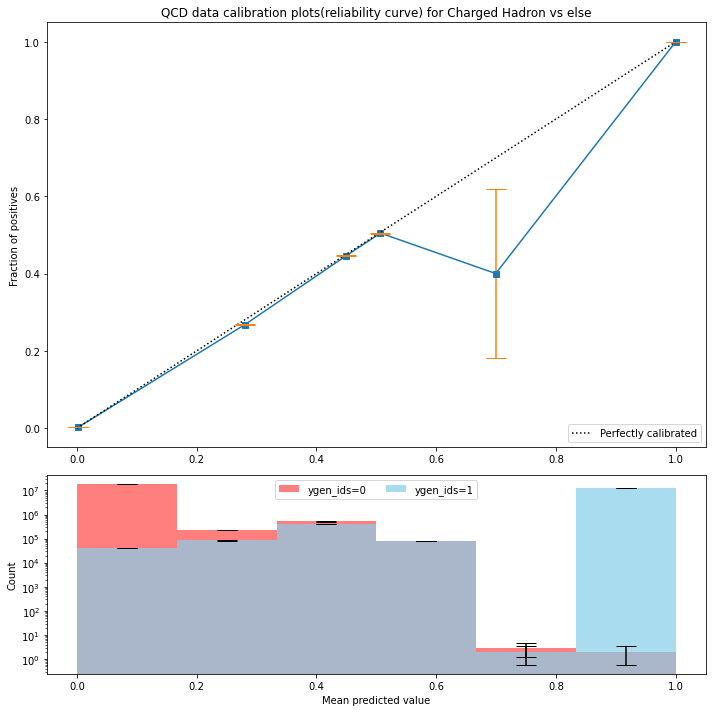

In [13]:
#calibration curve sklearn for Charged hadron vs else
import sklearn.calibration as calib
fraction_of_positives, mean_predicted_value=calib.calibration_curve(ygen_ids_CHb,ypred_CH1,normalize=True,n_bins=6,strategy="uniform")
#plotting https://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html#sphx-glr-auto-examples-calibration-plot-compare-calibration-py

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot(mean_predicted_value, fraction_of_positives, "s-",)


bins = np.linspace(0,1,len(fraction_of_positives)+1)
n_0, bins_0,_ = ax2.hist(ypred_CH[ygen_ids_CHb==0,1],density=False,log=True,bins=bins,color = "red",alpha=0.5,label="ygen_ids=0")
n_1, bins_1,_ = ax2.hist(ypred_CH[ygen_ids_CHb==1,1],density=False,log=True,bins=bins,color = "skyblue",alpha=0.7,label="ygen_ids=1")


ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('QCD data calibration plots(reliability curve) for Charged Hadron vs else')

#ax1 error
ax1_C ,ax1_errors  =  error(n_1,n_0)
print(ax1_errors)
yerr1 = ax1_errors
ax1.errorbar(mean_predicted_value, fraction_of_positives, yerr=yerr1, fmt='none',capsize =10)
#ax_C
ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)
#ax2 error histogram
ax2_C ,ax2_errors  =  error(n_1,n_0)
yerr2 = ax2_errors
bin_centers_0 = 0.5*(bins_0[1:] + bins_0[:-1])
bin_centers_1 = 0.5*(bins_1[1:] + bins_1[:-1])



yerr_0=np.sqrt(n_0)
yerr_1=np.sqrt(n_1)
ax2.errorbar(
    bin_centers_0,
    n_0,
    yerr = yerr_0,
    fmt="none",
    ecolor="black",
    capsize =10
)
ax2.errorbar(
    bin_centers_1,
    n_1,
    yerr = yerr_1,
    fmt="none",
    ecolor ="black",
    capsize =10
    
)


plt.tight_layout()
#plt.savefig('CH_vs_else_1st_example_data.png')
plt.show()

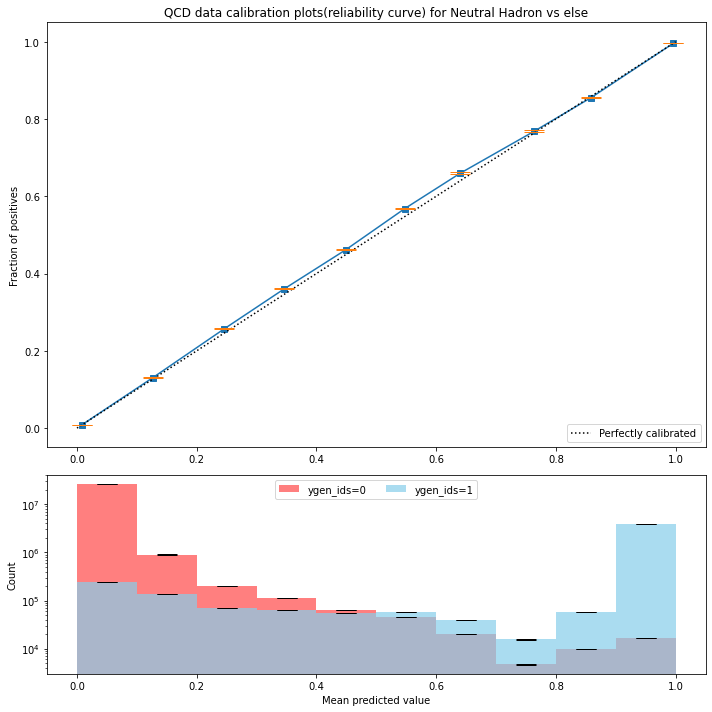

In [14]:
#calibration curve sklearn for Neutral hadron vs else
import sklearn.calibration as calib
fraction_of_positives, mean_predicted_value=calib.calibration_curve(ygen_ids_NHb,ypred_NH1,normalize=True,n_bins=10,strategy="uniform")
#plotting https://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html#sphx-glr-auto-examples-calibration-plot-compare-calibration-py

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot(mean_predicted_value, fraction_of_positives, "s-",)

bins = np.linspace(0,1,len(fraction_of_positives)+1)
n_0, bins_0,_ = ax2.hist(ypred_NH[ygen_ids_NHb==0,1],density=False,log=True,bins=bins,color = "red",alpha=0.5,label="ygen_ids=0")
n_1, bins_1,_ = ax2.hist(ypred_NH[ygen_ids_NHb==1,1],density=False,log=True,bins=bins,color = "skyblue",alpha=0.7,label="ygen_ids=1")


ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('QCD data calibration plots(reliability curve) for Neutral Hadron vs else')
#ax1 error
ax1_C ,ax1_errors  =  error(n_1,n_0)
yerr1 = ax1_errors
ax1.errorbar(mean_predicted_value, ax1_C, yerr=yerr1, fmt='none',capsize =10)


ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)
#ax2 error histogram
ax2_C ,ax2_errors  =  error(n_1,n_0)
yerr2 = ax2_errors
bin_centers_0 = 0.5*(bins_0[1:] + bins_0[:-1])
bin_centers_1 = 0.5*(bins_1[1:] + bins_1[:-1])

yerr_0=np.sqrt(n_0)
yerr_1=np.sqrt(n_1)
ax2.errorbar(
    bin_centers_0,
    n_0,
    yerr = yerr_0,
    fmt="none",
    ecolor="black",
    capsize =10
)
ax2.errorbar(
    bin_centers_1,
    n_1,
    yerr = yerr_1,
    fmt="none",
    ecolor ="black",
    capsize =10
    
)

plt.tight_layout()
#plt.savefig('NH_vs_else_QCD_data.png')
plt.show()

In [ ]:
## Testing error and calbration curve results.
#Eaxample
A= n_1
B= n_0
dA=np.sqrt(A)
dB=np.sqrt(B)
C= A/(A+B)
dC_dA=B/((A+B)**2)
dC_dB=-A/((A+B)**2)
errors=np.sqrt(((dC_dA*dA)**2)+((dC_dB*dB)**2))

print(f'A:{A}')
print(f'B:{B}')
print(f'C:{C}')
print(f'errors:{errors}')
print(f'bins returned:{len(fraction_of_positives)}')
print(f'fraction_of_positives:{fraction_of_positives}')

In [17]:
#Joosepi replicated version with confidence bins centers assigned in contrast to scikit methology where confidence 
#bin avrage is used.
def calibration_curve(labels_true, probas, n_bins): #Joosemi_remix
    bins = np.linspace(0., 1. + 1e-8, n_bins + 1)
    confidences = []
    accuracies = []
    for ib in range(len(bins)-1):
        msk_bin = (probas>=bins[ib]) & (probas<bins[ib+1])
        if np.sum(msk_bin) > 0:
            acc_bin = np.sum(labels_true[msk_bin]==1) / np.sum(msk_bin)
            confidences.append((bins[ib+1]-bins[ib])/2+bins[ib])
            accuracies.append(acc_bin)
    confidences = np.array(confidences)
    accuracies = np.array(accuracies)
    ece_val = np.sum(np.abs(confidences-accuracies))
    return confidences, accuracies

In [ ]:
def calibration_curve(y_true,y_prob, n_bins): #Scikit code implimentation
    bins = np.linspace(0., 1. + 1e-8, n_bins + 1)
    binids = np.digitize(y_prob, bins) - 1
    bin_sums = np.bincount(binids, weights=y_prob, minlength=len(bins))
    bin_true = np.bincount(binids, weights=y_true, minlength=len(bins))
    bin_total = np.bincount(binids, minlength=len(bins))

    nonzero = bin_total != 0
    prob_true = bin_true[nonzero] / bin_total[nonzero]
    #print(bin_true[nonzero],bin_total[nonzero])
    prob_pred = bin_sums[nonzero] / bin_total[nonzero]
    print(bin_sums[nonzero],bin_total[nonzero])
    return prob_true, prob_pred

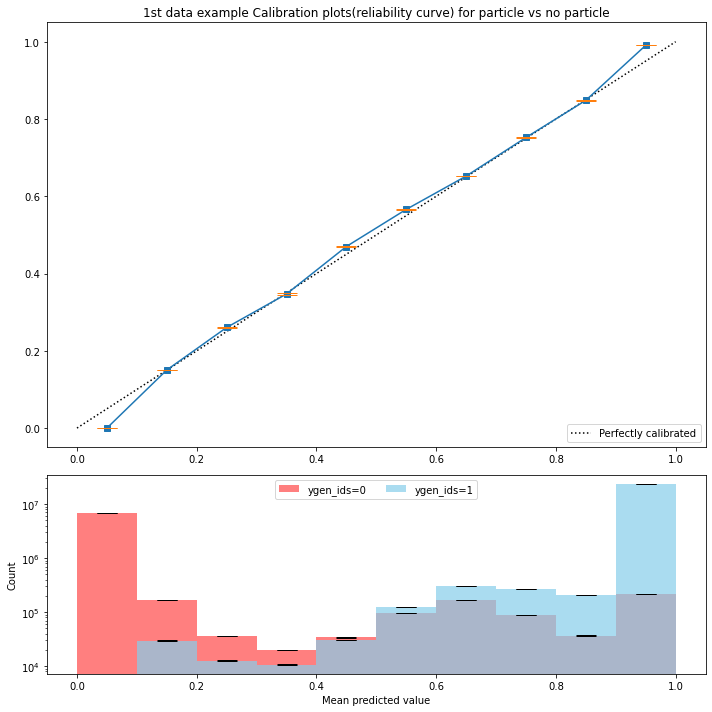

In [74]:
##Testing new  calibration curve

confidences , accuracies =calibration_curve(ygen_ids_b,ypred_1,10)

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.set_title('1st data example Calibration plots(reliability curve) for particle vs no particle')
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax1.legend(loc="lower right")
ax1.plot(confidences,accuracies, "s-",)

n_0, bins_0,_=ax2.hist(ypred_PVNP[ygen_ids_b==0,1],density=False,log=True,bins=bins,color = "red",alpha=0.5,label="ygen_ids=0")
n_1, bins_1,_ =ax2.hist(ypred_PVNP[ygen_ids_b==1,1],density=False,log=True,bins=bins,color = "skyblue",alpha=0.7,label="ygen_ids=1")
ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)
ax1_C,ax1_errors  =  error(n_1,n_0)
yerr1 = ax1_errors
##This is just testing error bars ax1_C
ax1.errorbar(confidences, ax1_C, yerr=yerr1, fmt='none',capsize =10)

#ax2 error histogram
ax2_C ,ax2_errors  =  error(n_1,n_0)
yerr2 = ax2_errors
bin_centers_0 = 0.5*(bins_0[1:] + bins_0[:-1])
bin_centers_1 = 0.5*(bins_1[1:] + bins_1[:-1])

yerr_0=np.sqrt(n_0)
yerr_1=np.sqrt(n_1)
ax2.errorbar(
    bin_centers_0,
    n_0,
    yerr = yerr_0,
    fmt="none",
    ecolor="black",
    capsize =10
)
ax2.errorbar(
    bin_centers_1,
    n_1,
    yerr = yerr_1,
    fmt="none",
    ecolor ="black",
    capsize =10
    
)


plt.tight_layout()
#plt.savefig('NH_vs_else_QCD_data.png')
plt.show()
#plt.savefig('Particle_vs_no_test.png')

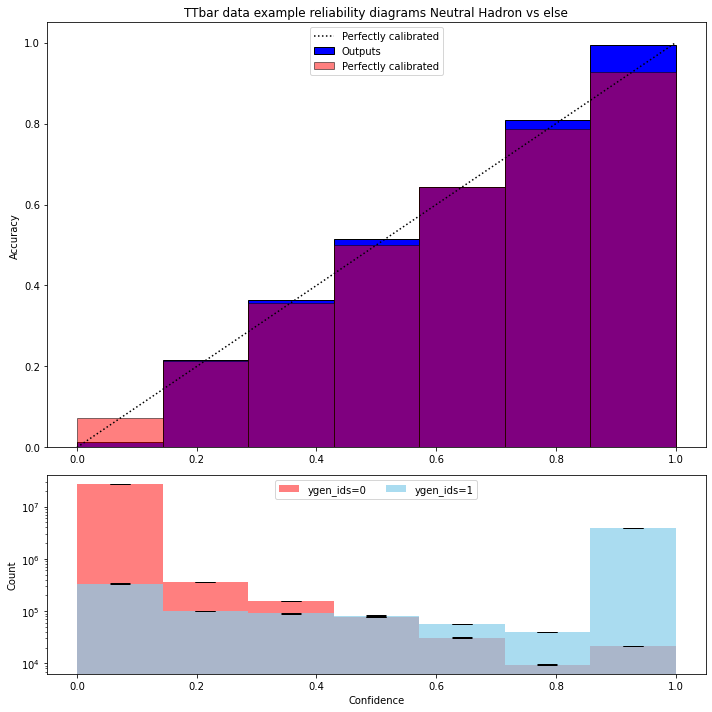

In [97]:
##Reproducing "figure 1".https://arxiv.org/pdf/1706.04599.pdf

confidences , accuracies =calibration_curve(ygen_ids_NHb,ypred_NH1,7)

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.set_title('TTbar data example reliability diagrams Neutral Hadron vs else')
ax1.bar(confidences, accuracies, width=1/len(confidences), facecolor='blue',alpha=1, edgecolor='black',label="Outputs")
ax1.bar(confidences, confidences, width=1/len(confidences), facecolor='red',alpha=0.5, edgecolor='black',label="Perfectly calibrated")
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax1.legend(loc="upper center")
ax1.set_ylabel("Accuracy")



bins = np.linspace(0,1,len(accuracies)+1)
n_0, bins_0,_=ax2.hist(ypred_NH[ygen_ids_NHb==0,1],density=False,log=True,bins=bins,color = "red",alpha=0.5,label="ygen_ids=0")
n_1, bins_1,_ =ax2.hist(ypred_NH[ygen_ids_NHb==1,1],density=False,log=True,bins=bins,color = "skyblue",alpha=0.7,label="ygen_ids=1")
ax2.set_xlabel("Confidence")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)


bin_centers_0 = 0.5*(bins_0[1:] + bins_0[:-1])
bin_centers_1 = 0.5*(bins_1[1:] + bins_1[:-1])

yerr_0=np.sqrt(n_0)
yerr_1=np.sqrt(n_1)
ax2.errorbar(
    bin_centers_0,
    n_0,
    yerr = yerr_0,
    fmt="none",
    ecolor="black",
    capsize =10
)
ax2.errorbar(
    bin_centers_1,
    n_1,
    yerr = yerr_1,
    fmt="none",
    ecolor ="black",
    capsize =10
    
)


plt.tight_layout()
#plt.savefig('NH_vs_else_TTbar_data_2.0.png')
plt.show()